In [27]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib widget
from IPython.display import display, clear_output
import random

## **Generación de la población**

In [28]:
def genera_poblacion(cant_pobladores, numero_bits):
    #Generación de la población inicial. Deben elegirse:
    # numero_bits = la cantidad de genes del cromosoma. A mayor numero de bits mayor coste computacional, pero mayor precisión en la representación de la función
    representaciones = 2**numero_bits #Cantidad de puntos que se podrán representar en la malla
    poblacion_inicial = random.sample(range(representaciones), cant_pobladores) # Se toma la muestra del número generado en el rango definido (0-2^n)
    #Codificación de la población
    poblacion_codificada = []
    for poblador in poblacion_inicial: #Para cada poblador, se aplicará la transformación a binario del número decimal obtenido
        poblacion_codificada.append( decimal_a_binario(poblador, representaciones, numero_bits) ) #El poblador será codificado a un gen binario (su tamaño dependerá de la resolución en bits escogida)
    return poblacion_codificada

### **Codificación del número decimal a representación binaria**

In [29]:
# Función para codificar el número decimal generado a número binario (para efectos de selección, cruza y mutación)
def decimal_a_binario(numero_decimal, rep, res_bits):
    numbin = []
    gene = 0
    if(numero_decimal>=0 and numero_decimal<=rep-1):
        while (gene <= res_bits-1):
            numbin.insert(0, numero_decimal % 2)
            numero_decimal //= 2
            gene+=1
    else:
        print("Número incompatible. No puede ser representado con los bits elegidos")
    return numbin

### **Decodificación del número binario a representación decimal**

In [30]:
#Funcion para decodificar el numero binario (poblador) a número decimal del 0-2^n. 
# Esto será útil para visualizar la progresión gráfica y recuperar el valor numérico en X, Y, y Z de la solución más apta encontrada
def binario_a_decimal(poblacion):
    pob_decod = []
    for individuo in poblacion:
        valor = 0
        i=0
        cadena_aux = individuo[::-1] #Invierte la cadena
        while i<len(individuo):
            valor += cadena_aux[i] * 2**i #Convierte a valor decimal el binario
            i = i + 1
        pob_decod.append(valor)  #Guarda en una nueva lista el valor decodificado del poblador (decimal)
    return pob_decod

### **Mapeo del número decimal a índices en la matriz de la función con los valores evaluados de los puntos**

In [31]:
#Función para recuperar, a partir del valor decimal del poblador, el índice asociado, en la matriz de coordenadas original
def recuperacion_indices(pobdecodificada, forma_mat_orig):
    fila = []
    columna = []
    for pob_dec in pobdecodificada: #Para cada poblador, el número decimal será utilizado para determinar su índice de fila y columna
        fila.append(    int( pob_dec // forma_mat_orig ) ) #La fila será la división entera del número decimal, y la dimensión de la matriz
        columna.append( int( pob_dec % forma_mat_orig ) ) #La columna será el residuo entre el número decimal, y la dimensión de la matriz
    return fila, columna

## **Función de aptitud**

In [32]:
def evaluacion_aptitud(poblacion, funcion_a_evaluar):
    #Función que evalúa la aptitud de cierto número de pobladores, contra la función tridimensional a minimizar, después de decodificarla.
    aptitud = []
    poblacion_decodificada = []
    poblacion_decodificada = binario_a_decimal(poblacion)
    matriz_con_aptitud = pd.DataFrame()
    filas, columnas = recuperacion_indices(poblacion_decodificada, funcion_a_evaluar.shape[0])
    aptitud = funcion_a_evaluar[filas, columnas] # Aptitud del individuo: Valor de la función en el índice recuperado
    matriz_con_aptitud["POBLACION"] = poblacion #Valor de bits con alelos {0,1} del individuo
    matriz_con_aptitud["APTITUD"] = aptitud #Aptitud del individuo
    matriz_con_aptitud["FILA"] = filas
    matriz_con_aptitud["COLUMNA"] = columnas#Valor decodificado (útil para graficar)
    return matriz_con_aptitud

## **Métodos de cruza**

### **Cruza por un corte**

In [33]:
def cruza_un_corte(padre1, padre2):
    num_genes = len(padre1)
    hijo_1 = padre1[0:int(num_genes/2)] + padre2[int(num_genes/2):num_genes]
    hijo_2 = padre2[0:int(num_genes/2)] + padre1[int(num_genes/2):num_genes]
    return hijo_1, hijo_2

### **Cruza homogénea**

In [34]:
def cruza_homogenea(padre1, padre2):
    num_genes = len(padre1)
    hijo_1 = []
    hijo_2 = []
    for i in range(num_genes):
        gen_padre = random.randint(0, 1)
        if (gen_padre == 0):
            hijo_1.append(padre1[i])
            hijo_2.append(padre2[i])
        else:
            hijo_1.append(padre2[i])
            hijo_2.append(padre1[i])

    return hijo_1, hijo_2

## **Métodos de selección**

### **Aleatorio monogámico**

In [35]:
def aleatorio_monogamico(poblacion):
    n = len(poblacion) #n = numero de elementos a obtener (hijos)
    num_genes = len(poblacion[0]) #Calcula el numero de genes (por si en algun punto debe escalar a más genes pares)
    i = 0
    poblacion_disponible = poblacion.to_list().copy()
    poblacion_hijos = []
    while ( i < (n/2) ):
        #Hijos generados (dos posibles, por cada pareja de padres seleccionados, cada pareja es seleccionada aleatoriamente una sola vez)
        pareja = random.sample(poblacion_disponible, 2)

        #hijo_1, hijo_2 = cruza_un_corte(pareja[0], pareja[1]) #CRUZA UN CORTE
        hijo_1, hijo_2 = cruza_homogenea(pareja[0], pareja[1]) # CRUZA HOMOGÉNEA
        poblacion_hijos.append(hijo_1)
        poblacion_hijos.append(hijo_2)
        poblacion_disponible.remove(pareja[0])
        poblacion_disponible.remove(pareja[1])
        i+=1
    return poblacion_hijos

### **Torneo**

In [36]:
def tournament(poblacion):
    n = len(poblacion) #n = numero de elementos a obtener (hijos)
    num_genes = len(poblacion[0]) #Calcula el numero de genes (por si en algun punto debe escalar a más genes pares)
    i = 0
    poblacion_disponible = poblacion.to_list().copy()
    poblacion_hijos = []
    while ( i < (n/2) ):
        #Hijos generados (forzosamente con población previamente ordenada), se cruzan padres 1-10, 2-9, 3-8, y así sucesivamente
        hijo_1, hijo_2 = cruza_un_corte(poblacion[i], poblacion[n-1-i]) #CRUZA UN CORTE
        #hijo_1, hijo_2 = cruza_homogenea(poblacion[i], poblacion[n-1-i]) #CRUZA HOMOGÉNEA
        poblacion_hijos.append(hijo_1)
        poblacion_hijos.append(hijo_2)
        i+=1
    return poblacion_hijos

### **Ranking**

In [37]:
def rank_selection(poblacion):
    n = len(poblacion) #n = numero de elementos a obtener (hijos)
    num_genes = len(poblacion[0]) #Calcula el numero de genes (por si en algun punto debe escalar a más genes pares)
    i = 0
    poblacion_hijos = []
    while ( i < n ):
        #Hijos generados (dos posibles, por cada pareja de padres seleccionados)
        #hijo_1, hijo_2 = cruza_un_corte(poblacion[i], poblacion[i+1]) # CRUZA 1 CORTE
        hijo_1, hijo_2 = cruza_homogenea(poblacion[i], poblacion[i+1]) # CRUZA HOMOGÉNEA
        
        poblacion_hijos.append(hijo_1)
        poblacion_hijos.append(hijo_2)
        i+=2
    return poblacion_hijos

## **Mutación por inversión simple**

In [38]:
def mutacion_inversion_simple(poblacion, porc_mut):
    # Porc_mut = porcentaje de individuos hijos a mutar (en decimal)
    # poblacion_hijos = poblacion total de hijos en una generación dada
    i = random.randint(-3,3)
    
    cant_hijos_mutados = int(len(poblacion) * porc_mut)
    hijos_a_mutar = poblacion[ len(poblacion) - cant_hijos_mutados: ]
    
    indice = int(np.round(len(hijos_a_mutar[0])/3))
    mutados = []
    
    for individuo in hijos_a_mutar:
        subcadena = individuo[ indice+i : (2*indice)+i ]
        cromosoma = individuo[ 0:indice+i ] + individuo[ (2*indice)+i : ]

        subcadena_invertida = [1 if x == 0 else 0 for x in subcadena]
    
        mutados.append(cromosoma[0:indice+i] + subcadena_invertida + cromosoma[indice+i:])
    poblacion[len(poblacion) - cant_hijos_mutados: ] = mutados

## **Cálculo de la función, a partir de X, Y**

In [39]:
def calculo_funcion(x,y):
    
    primer_termino = 0
    segundo_termino = 0
    
    for i in range(1,6):
        primer_termino += ( i * np.cos( (i+1) * x + i ) )
        segundo_termino += ( i * np.cos( (i+1) * y + i ) )
        
    z = primer_termino * segundo_termino
    return z

## **Progreso gráfico de las soluciones**

In [40]:
def grafica_soluciones(X1,X2,matriz_con_aptitud,i, fig, ax):
    
    X_graph, Y_graph = np.meshgrid(X1, X2)
    Z_graph = calculo_funcion(X_graph, Y_graph)
    
    ax.clear()
    ax.contour3D(X_graph, Y_graph, Z_graph, levels = 100, cmap='viridis',alpha=0.2, linewidths = 3)

    x = X1[matriz_con_aptitud["FILA"]]
    y = X2[matriz_con_aptitud["COLUMNA"]]
    z = Z_graph[matriz_con_aptitud["FILA"], matriz_con_aptitud["COLUMNA"]]
    
    ax.scatter(x, y, z, s=15, color = "red", label = 'Soluciones')
    leyenda = 'Mejor aptitud = {:.2f}, Generación {:d}, X = {:.2f}, Y = {:.2f}'.format(matriz_con_aptitud["APTITUD"][0], i, x[0], y[0])
    ax.set_title(leyenda, weight ="bold");
    ax.legend(loc = "upper center")
    ax.set_xlabel('X', weight = 'bold')
    ax.set_ylabel('Y', weight = 'bold')
    ax.set_zlabel('Z', weight = 'bold')
    display(fig)
    clear_output(wait=True)

## **Algoritmo genético completo**

In [41]:
# Aplicación de la función para evaluar la aptitud de los pobladores
def algoritmo_genetico(poblacion_codificada, nbits=16, generaciones = 100, diferencia = 0.00001,rinic= -10, rfin = 10):
    if (nbits % 2 != 0):
        raise ValueError("El valor de bits (o genes del cromosoma) debe ser par")
        
    aptitud_acumulada = []
    apt_minima_acumulada = []
    apt_ant = 1

    num_punt = int( np.sqrt( 2 ** nbits ) )
    
    X1 = np.linspace(rinic, rfin, num_punt)
    X2 = np.linspace(rinic, rfin, num_punt)
    
    X, Y = np.meshgrid(X1, X2)
    funcion = calculo_funcion(X, Y)

    matriz_con_aptitud = evaluacion_aptitud(poblacion_codificada, funcion)
    matriz_con_aptitud = matriz_con_aptitud.sort_values(by="APTITUD", ascending = True).reset_index(drop=True) # Ordenamiento de los pobladores

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(projection='3d')
    
    grafica_soluciones(X1,X2,matriz_con_aptitud,0,fig,ax)
    #grafica = f"generacion_{0}.png"
    #fig.savefig(grafica)
    
    for i in range(1,generaciones+1):
#METODOS DE SELECCION (LOS MÉTODOS DE CRUZA VAN DEFINIDOS DENTRO DE CADA METODO DE SELECCION. LA INSTRUCCION PARA CAMBIAR DE METODO DE CRUZA SE ENCUENTRA COMENTADA
        #ALEATORIO MONOGAMICO
        #poblacion_hijos = aleatorio_monogamico(matriz_con_aptitud["POBLACION"])
        #TORNEO
        poblacion_hijos = tournament(matriz_con_aptitud["POBLACION"])
        #RANKING
        #poblacion_hijos = rank_selection(matriz_con_aptitud["POBLACION"])

        mutacion_inversion_simple(poblacion_hijos, 0.1)
        matriz_con_aptitud_hijos = evaluacion_aptitud(poblacion_hijos,funcion)
        #Juntar hijos con padres, para ordenarlos y seleccionar mejores pobladores
        matriz_mixed = pd.concat([matriz_con_aptitud, matriz_con_aptitud_hijos], ignore_index=True)
        matriz_final = matriz_mixed.sort_values(by="APTITUD", ascending = True).reset_index(drop=True)
        #MÉTODO ELITISTA: Seleccionar mejores individuos (Competencia genética)
        matriz_con_aptitud = matriz_final[0:int(len(matriz_final)/2)]

        aptitud_acumulada.append(matriz_con_aptitud["APTITUD"][0])
        apt_minima_acumulada.append(matriz_con_aptitud["APTITUD"][len(matriz_con_aptitud)-1])
        
        if(i%5==0):
            grafica_soluciones(X1,X2,matriz_con_aptitud,i,fig,ax)
            #grafica = f"generacion_{i}.png"
            #fig.savefig(grafica)
                        
        if( i > 5  and ( np.mean(aptitud_acumulada[-5:]) == np.mean(apt_minima_acumulada[-5:]) or ( abs(np.mean(matriz_con_aptitud["APTITUD"])-apt_ant) < diferencia ) )  ):
            grafica_soluciones(X1,X2,matriz_con_aptitud,i,fig,ax)
            break;
        apt_ant = np.mean(matriz_con_aptitud["APTITUD"])
    print("Minimo encontrado en X = ", X1[matriz_con_aptitud["FILA"][0]], ", Y = ", X2[matriz_con_aptitud["COLUMNA"][0]])
    return matriz_con_aptitud, X1, X2, i

## **Generación de poblaciones para comparación de resultados**

In [42]:
poblaciones = []
random.seed(20)
genes = [14, 16, 18]
pobladores = [200, 400, 1000]

for cant_genes in genes:
    pobcod = []
    for cant_pobladores in pobladores:
        pobcod = genera_poblacion(cant_pobladores, cant_genes)
        poblaciones.append(pobcod)

In [43]:
print("--ESPECIFICACIONES DE POBLACIONES GENERADAS--\n")
for i in range(len(poblaciones)):
    print("Cantidad de pobladores:", len(poblaciones[i]), "\tGenes por poblador: ", len(poblaciones[i][0]), "\tNombre de población: poblaciones[", i,"]")

--ESPECIFICACIONES DE POBLACIONES GENERADAS--

Cantidad de pobladores: 200 	Genes por poblador:  14 	Nombre de población: poblaciones[ 0 ]
Cantidad de pobladores: 400 	Genes por poblador:  14 	Nombre de población: poblaciones[ 1 ]
Cantidad de pobladores: 1000 	Genes por poblador:  14 	Nombre de población: poblaciones[ 2 ]
Cantidad de pobladores: 200 	Genes por poblador:  16 	Nombre de población: poblaciones[ 3 ]
Cantidad de pobladores: 400 	Genes por poblador:  16 	Nombre de población: poblaciones[ 4 ]
Cantidad de pobladores: 1000 	Genes por poblador:  16 	Nombre de población: poblaciones[ 5 ]
Cantidad de pobladores: 200 	Genes por poblador:  18 	Nombre de población: poblaciones[ 6 ]
Cantidad de pobladores: 400 	Genes por poblador:  18 	Nombre de población: poblaciones[ 7 ]
Cantidad de pobladores: 1000 	Genes por poblador:  18 	Nombre de población: poblaciones[ 8 ]


## **Ejemplificación de la solución**

Minimo encontrado en X =  -0.8023483365949122 , Y =  -1.4285714285714288


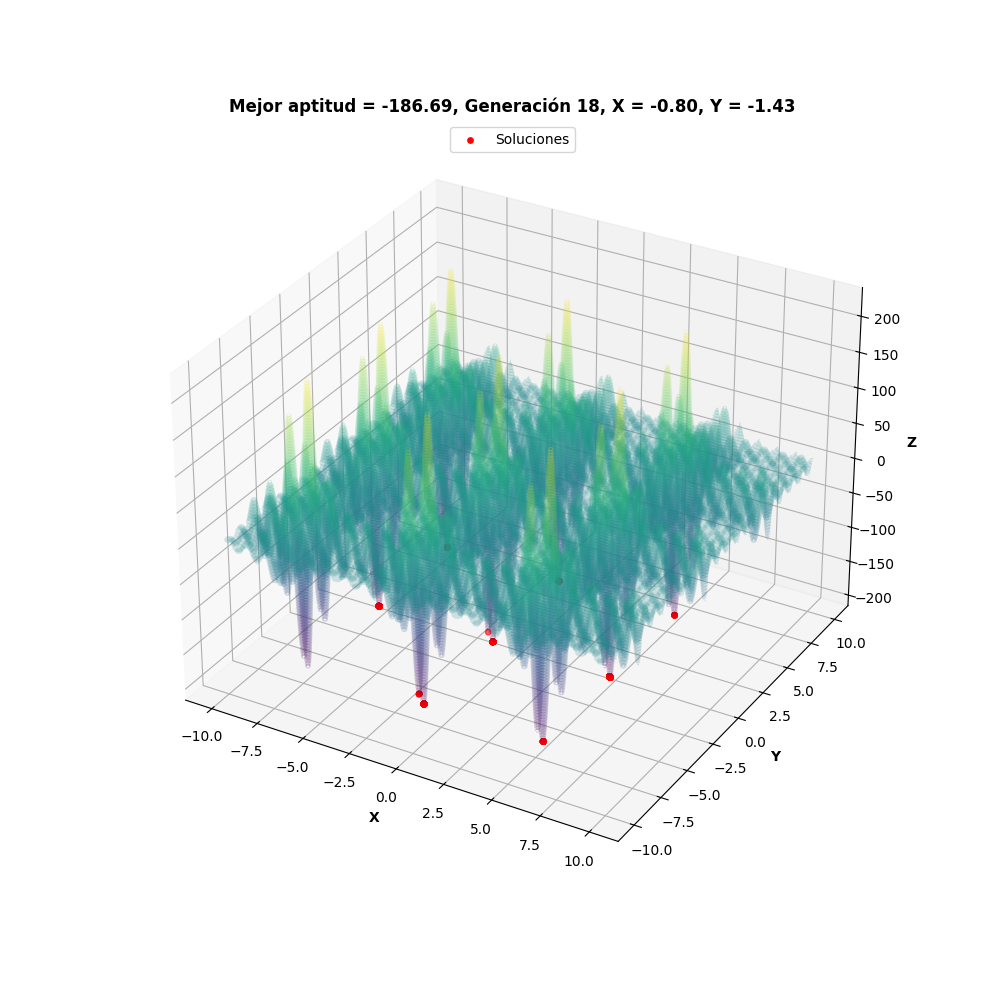

In [44]:
poblacion_por_evaluar = poblaciones[8]
diferencia = 0.5
RESULTADOS, X, Y, generaciones = algoritmo_genetico(poblacion_por_evaluar, len(poblacion_por_evaluar[0]), 100, diferencia)

In [45]:
x_, y_ = np.meshgrid(X,Y)
Z = calculo_funcion(x_, y_)
print("VALOR MÍNIMO ALCANZABLE DE LA FUNCIÓN:",np.min(Z), "CON RESOLUCIÓN DE MALLA DE", Z.shape, "VALORES POSIBLES")

VALOR MÍNIMO ALCANZABLE DE LA FUNCIÓN: -186.6942269099631 CON RESOLUCIÓN DE MALLA DE (512, 512) VALORES POSIBLES


In [46]:
RESULTADOS["APTITUD"].unique()

array([-186.69422691, -186.2133719 , -186.12819297, -186.0039092 ,
       -185.91460418, -185.79895293, -185.64879585, -185.53397083,
       -185.43996822, -185.43575719])

In [47]:
RESULTADOS[ RESULTADOS["APTITUD"] == RESULTADOS["APTITUD"].unique()[0] ] 

POBLACION     APTITUD  FILA  \
0    [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ... -186.694227   235   
1    [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ... -186.694227   235   
2    [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ... -186.694227   235   
3    [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ... -186.694227   235   
4    [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ... -186.694227   235   
..                                                 ...         ...   ...   
145  [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ... -186.694227   235   
146  [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ... -186.694227   235   
147  [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ... -186.694227   235   
148  [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ... -186.694227   235   
149  [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ... -186.694227   235   

     COLUMNA  
0        219  
1        219  
2        219  
3        219  
4        219  
..       ...  
145      219  
146      219  
147      219  
148      219  
149      219  

[150 rows x 4 columns]

In [48]:
RESULTADOS

POBLACION     APTITUD  FILA  \
0    [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ... -186.694227   235   
1    [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ... -186.694227   235   
2    [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ... -186.694227   235   
3    [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ... -186.694227   235   
4    [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ... -186.694227   235   
..                                                 ...         ...   ...   
995  [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, ... -185.435757    75   
996  [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, ... -185.435757    75   
997  [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, ... -185.435757    75   
998  [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, ... -185.435757    75   
999  [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, ... -185.435757    75   

     COLUMNA  
0        219  
1        219  
2        219  
3        219  
4        219  
..       ...  
995      380  
996      380  
997      380  
998      380  
999      380  

[1000 rows x 4 columns]

In [49]:
filtro_minimos = RESULTADOS[ RESULTADOS["APTITUD"] == RESULTADOS["APTITUD"].unique()[0] ].copy()
filtro_minimos.loc[:,"INDICES"] = filtro_minimos.apply(lambda row: f"{row['FILA']}, {row['COLUMNA']}", axis=1) 
cant_minimos = filtro_minimos["INDICES"].nunique()
indices_X = filtro_minimos["FILA"].unique()
indices_Y = filtro_minimos["COLUMNA"].unique()
print("Minimos Globales Encontrados: ",cant_minimos)
print("Indices en X = ", indices_X)
print("Indices en Y = ", indices_Y)

Minimos Globales Encontrados:  2
Indices en X =  [235 219]
Indices en Y =  [219 235]


In [50]:
X_, Y_ = np.meshgrid(X,Y)
func = calculo_funcion(X_,Y_)
print("Rango de valores de la función en X: ", np.min(X_), " a ", np.max(X_) )
print("Rango de valores de la función en Y: ", np.min(Y_), " a ", np.max(Y_) )
print("Valores posibles que puede tomar la función: ", len(func.flatten()))

Rango de valores de la función en X:  -10.0  a  10.0
Rango de valores de la función en Y:  -10.0  a  10.0
Valores posibles que puede tomar la función:  262144


In [51]:
# Evaluar X_ y Y_ en indices minimos encontrados (DE ACUERDO CON LOS MINIMOS GLOBALES ENCONTRADOS Y LOS INDICES ARROJADOS)
#print("Minimo en: ", X_[235, 219], "X", Y_[235, 219], "Y")
#print("Minimo en: ", X_[219, 235], "X", Y_[219, 235], "Y")

Minimo encontrado en X =  -0.8023483365949122 , Y =  -1.4285714285714288


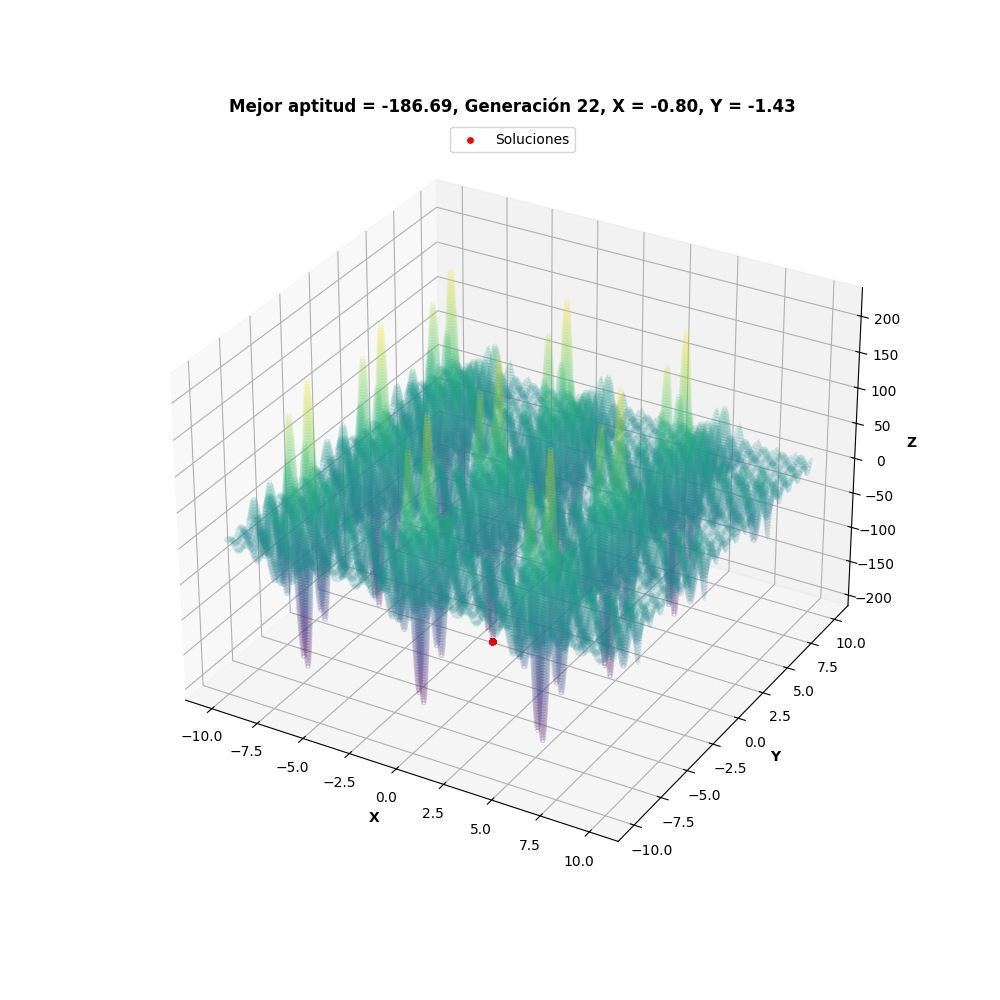

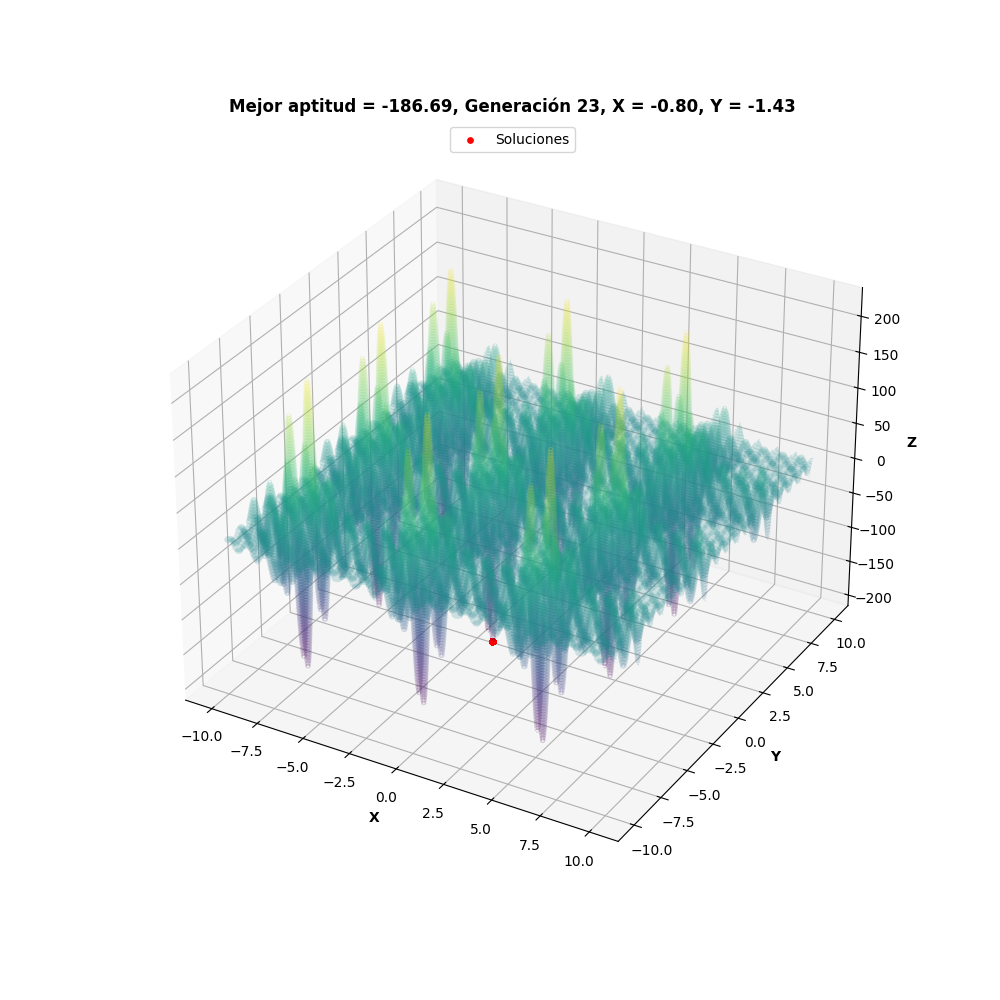

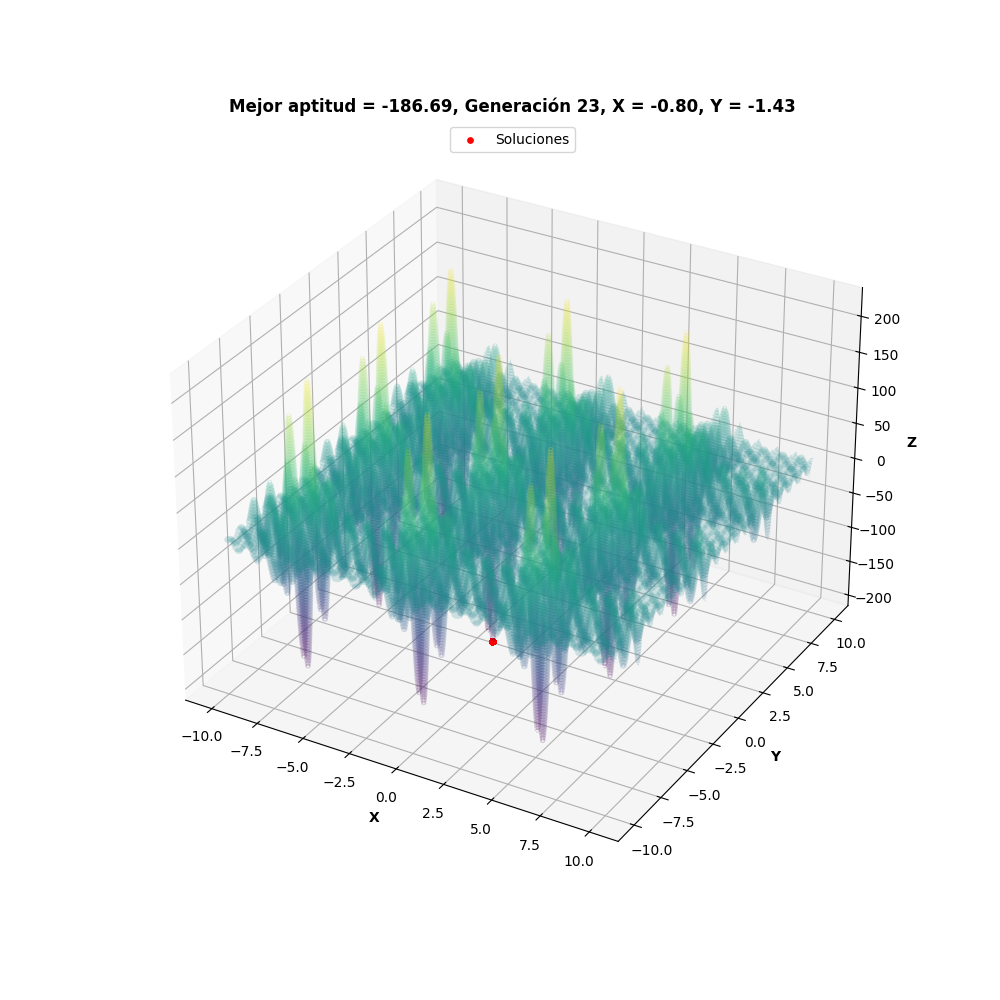

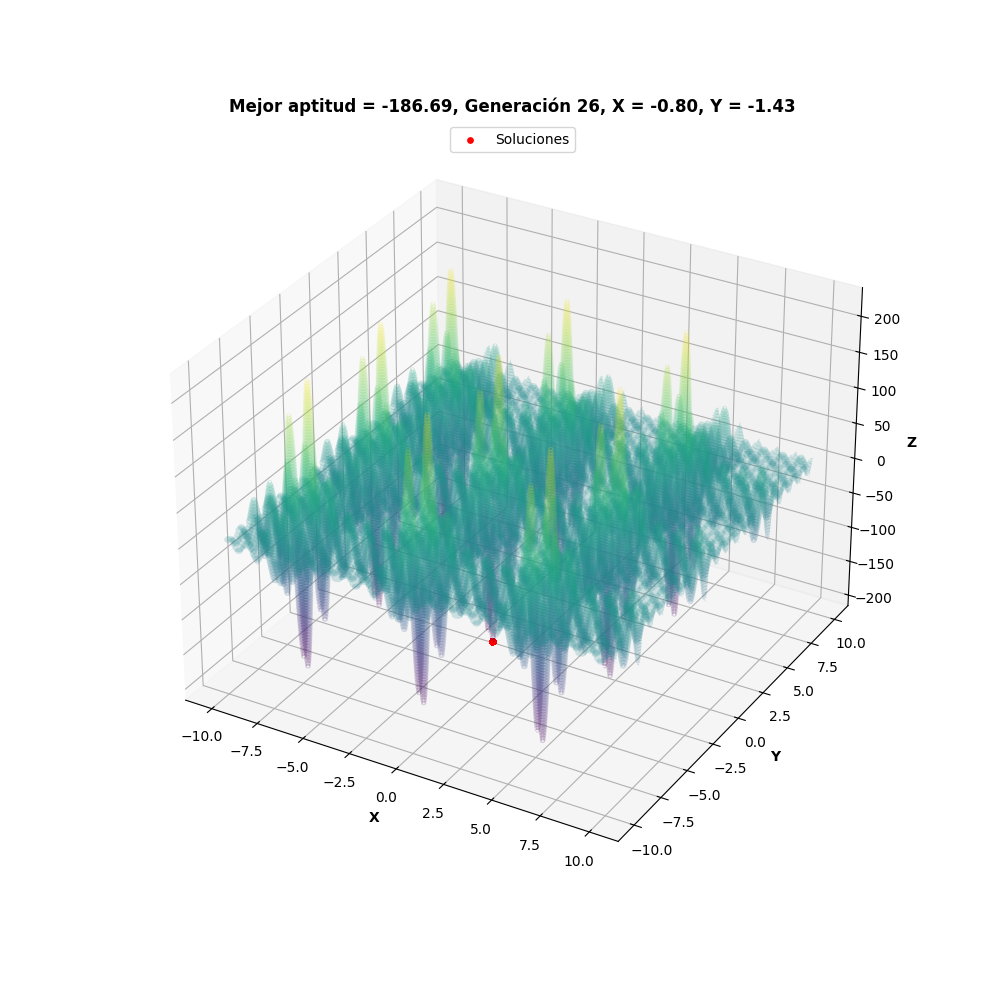

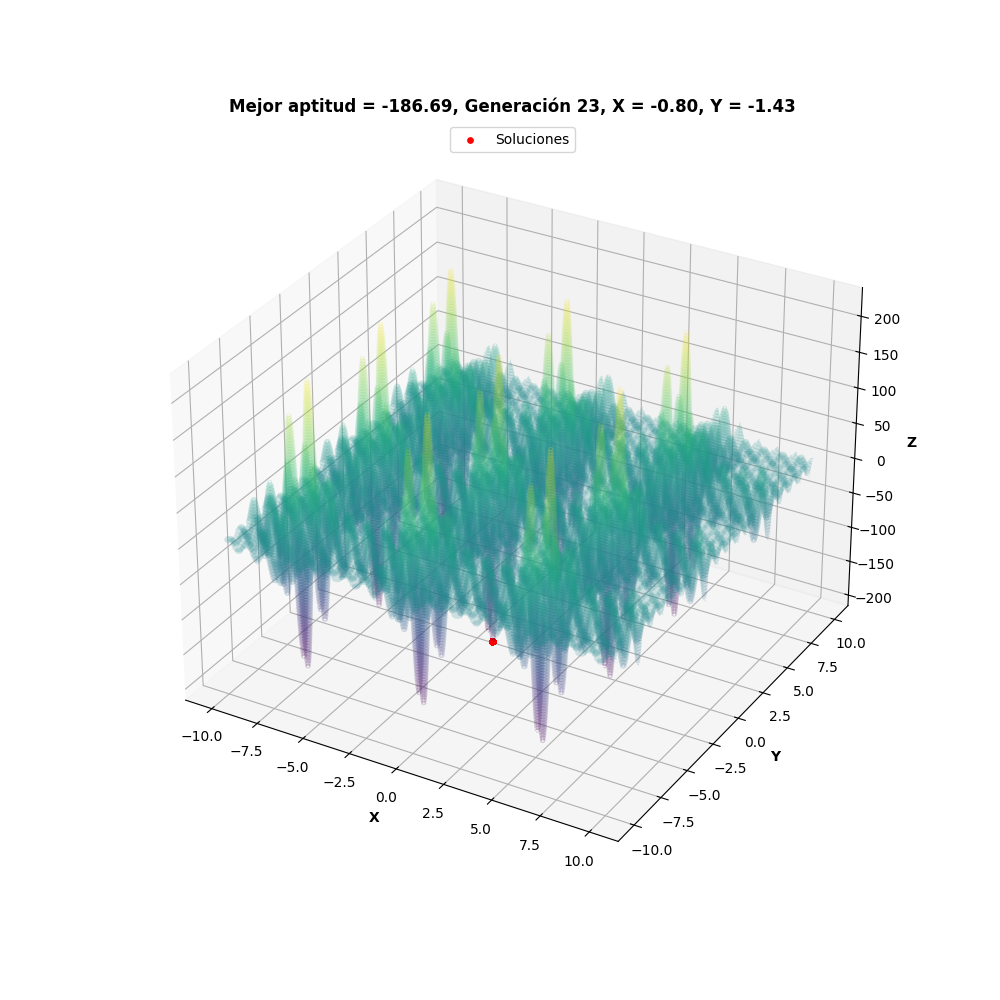

In [52]:
poblacion_por_evaluar = poblaciones[8]
RESULTADOS = pd.DataFrame(columns = ["Mejor Aptitud", "Peor aptitud", "Generaciones"])
experimento_1 = []
experimento_2 = []
generaciones = []

for i in range(5):
    resultados, X, Y, generacion = algoritmo_genetico(poblacion_por_evaluar, len(poblacion_por_evaluar[0]), 100)
    experimento_1.append(resultados["APTITUD"][0])
    experimento_2.append(resultados["APTITUD"][len(poblacion_por_evaluar)-1])
    generaciones.append(generacion)
RESULTADOS["Mejor Aptitud"] = experimento_1
RESULTADOS["Peor aptitud"] = experimento_2
RESULTADOS["Generaciones"] = generaciones

In [53]:
RESULTADOS

Mejor Aptitud  Peor aptitud  Generaciones
0    -186.694227   -186.694227            22
1    -186.694227   -186.694227            23
2    -186.694227   -186.694227            23
3    -186.694227   -186.694227            26
4    -186.694227   -186.694227            23